# Model the Census Bureau Data - a binary classification (salary category)

## import libraries

In [254]:
import pandas as pd
import numpy as np
import dill as pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelBinarizer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline

## Helper Functions

In [255]:
def load_file(file):
    '''loads csv to pd dataframe'''
    return pd.read_csv(file)

# def one_hot_encode_feature_df(df, cat_vars=None, num_vars=None):
#     '''performs one-hot encoding on all categorical variables and combines result with continuous variables'''
#     cat_df = pd.get_dummies(df[cat_vars])
#     num_df = df[num_vars].apply(pd.to_numeric)
#     return pd.concat([cat_df, num_df], axis=1)#,ignore_index=False)

def get_columns_from_transformer(column_transformer, input_colums):    
    col_name = []

    for transformer_in_columns in column_transformer.transformers_: #the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names(raw_col_name)
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)

    # print(col_name)
    return col_name


def one_hot_encode_feature_df(df, col_transformer):
    '''performs one-hot encoding on all categorical variables and combines result with continuous variables'''
    processed_df = pd.DataFrame.sparse.from_spmatrix(col_transformer.transform(df))
    processed_df.columns = get_columns_from_transformer(col_transformer, df.columns)
    return(processed_df)

def generate_feature_encoding(df, cat_vars=None, num_vars=None):
    '''performs one-hot encoding on all categorical variables and combines result with continuous variables'''
    ohe = OneHotEncoder()
    numft = FunctionTransformer(lambda x: x.apply(pd.to_numeric), accept_sparse=True)
    ct = ColumnTransformer(
        [
            ("ohe", ohe, cat_vars), 
            ("nuft", numft, num_vars)
        ],  
        remainder='drop')
    
    ct.fit(df)
    return (ct)

def get_target_df(df, target):
    '''returns target dataframe'''
    df.pop(target_var)
    return df[target]

def train_model(model, feature_df, target_df, num_procs, roc_auc_dict, cv_std):
    '''performs cross validation with the model provided ad stores results in dictionaries'''
    roc_auc = cross_val_score(model, feature_df, target_df, cv=5, n_jobs=num_procs, scoring='roc_auc_ovr')
    roc_auc_dict[model] = roc_auc
    cv_std[model] = np.std(roc_auc)
    # import sklearn.metrics
    # sorted(sklearn.metrics.SCORERS.keys())

def get_best_model(roc_auc_dict):
    '''return the model with the best performance'''
    best_score = 0
    for key, value in roc_auc_dict.items():
        if np.mean(value) >= best_score:
            model = key
    print('\nModel with highest roc_auc:')
    print(model)
    return(model)

def print_summary(model, roc_auc_dict, cv_std):
    '''prints performance of the model provided'''
    print('\nModel:\n', model)
    print('Average roc_auc :\n', roc_auc_dict[model])
    print('Standard deviation during CV:\n', cv_std[model])

# resource: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
def plot_results(model, feature_df, target_df):
    '''plot roc curve of model provided'''
    
    # binarize label - 0, 1
    lb = LabelBinarizer()
    target_binary_df = lb.fit_transform(target_df)

    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(target_binary_df))]
    # predict probabilities
    model_probs = model.predict_proba(feature_df)
    # keep probabilities for the positive outcome only
    model_probs = model_probs[:, 1]

    # calculate scores
    ns_auc = roc_auc_score(target_df, ns_probs)
    model_auc = roc_auc_score(target_df, model_probs)

    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(str(model)+': ROC AUC=%.3f' % (model_auc))
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(target_binary_df, ns_probs)
    model_fpr, model_tpr, _ = roc_curve(target_binary_df, model_probs)
    
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(model_fpr, model_tpr, marker='.', label=str(model))
        # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # show the plot
    plt.show()

def save_results(model, feature_encoding_transformer, roc_auc_dict, feature_importances, model_dir):
    '''saves feature_encoding , model summary, feature importances'''

    # model
    encoding_file_name = 'census_feature_encoding.pkl'
    pickle.dump(feature_encoding_transformer, open(model_dir + encoding_file_name, 'wb'))
    
    # Model name   
    with open(model_dir+'model.txt', 'w') as file:
        file.write(str(model))
    
    # model
    model_file_name = 'census_model.pkl'
    pickle.dump(model, open(model_dir + model_file_name, 'wb'))
    
    # feature importance
    feature_importances.to_csv(model_dir+'feature_importances.csv') 

## Data Loading and Preprocessing

In [262]:
#define inputs
train_file = '../data/census_clean.csv'
model_dir = '../model/'

#define variables
cat_features = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
]
numeric_features = ["age","fnlgt","education-num","capital-gain","capital-loss","hours-per-week"]
target_var = "salary"

# load data
print("Loading data")
train_df = load_file(train_file)


# shuffle, and reindex training data -- shuffling improves cross-validation accuracy
print("Shuffling data")
train_df = shuffle(train_df)
display(train_df.columns)

# get target df
print("Retrieving labels")
target_df = train_df.pop(target_var)

# encode categorical data and get final feature dfs
print("Encoding data")
ct = generate_feature_encoding(
    train_df, cat_vars=cat_features, num_vars=numeric_features
)
feature_df = one_hot_encode_feature_df(train_df, ct)

#ct.transformers_
#ct.named_transformers_["ohe"].get_feature_names()
#ct.named_transformers_["nuft"]
#get_columns_from_transformer(ct, train_df.columns)
#ct.transformers_[-1][1]
#ct.named_transformers_["ohe"]

Loading data
Shuffling data


Index(['age', 'workclass', 'fnlgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'salary'],
      dtype='object')

Retrieving labels
Encoding data


In [263]:
train_df.columns


Index(['age', 'workclass', 'fnlgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

## Modelling

### Initialize model variables

In [264]:
#initialize model list and dicts
models = []
roc_auc_dict = {}
cv_std = {}
res = {}

#define number of processes to run in parallel
num_procs = -1

#shared model paramaters
verbose_lvl = 0

### Cross validation

In [265]:
#create models -- hyperparameter tuning already done by hand for each model
rf = RandomForestClassifier(n_estimators=150, n_jobs=num_procs, max_depth=25, min_samples_split=60, \
                           max_features=30, verbose=verbose_lvl)

gbc = GradientBoostingClassifier(n_estimators=150, max_depth=5, loss='exponential', verbose=verbose_lvl)                           

models.extend([rf, gbc])

#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    train_model(model, feature_df, target_df, num_procs, roc_auc_dict, cv_std)
    print_summary(model, roc_auc_dict, cv_std)

Beginning cross validation

Model:
 RandomForestClassifier(max_depth=25, max_features=30, min_samples_split=60,
                       n_estimators=150, n_jobs=-1)
Average roc_auc :
 [0.91013174 0.91834444 0.915296   0.91684945 0.92265875]
Standard deviation during CV:
 0.004082567414809937

Model:
 GradientBoostingClassifier(loss='exponential', max_depth=5, n_estimators=150)
Average roc_auc :
 [0.92210665 0.92943992 0.92780595 0.92664311 0.93421009]
Standard deviation during CV:
 0.003930406166682518


### Pick Best Performing model

In [266]:
# choose model with best auc_roc
best_model = get_best_model(roc_auc_dict)

# train best model on entire dataset
print("Fit best performing model")
best_model.fit(feature_df, target_df)


Model with highest roc_auc:
GradientBoostingClassifier(loss='exponential', max_depth=5, n_estimators=150)
Fit best performing model


GradientBoostingClassifier(loss='exponential', max_depth=5, n_estimators=150)

No Skill: ROC AUC=0.500
GradientBoostingClassifier(loss='exponential', max_depth=5, n_estimators=150): ROC AUC=0.942


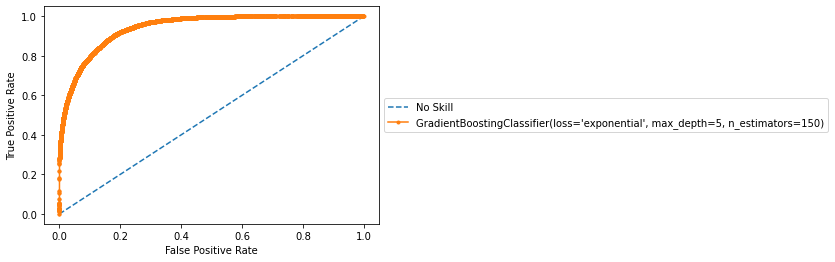

In [267]:
plot_results(best_model, feature_df, target_df)

### Save Results and Best Model

Save model and featue importances


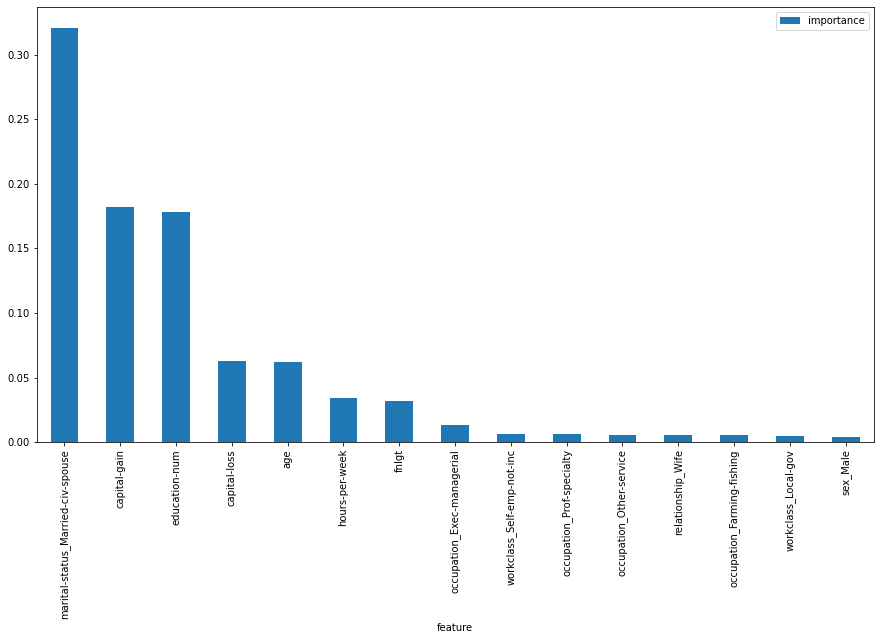

In [268]:
# Save feature importances
print("Save model and featue importances")
importances = best_model.feature_importances_
feature_importances = pd.DataFrame({'feature':feature_df.columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.set_index('feature', inplace=True, drop=True)

# plot feature importances
feature_importances[0:15].plot.bar(figsize=(15,8))
plt.show()

#save feature encoder, model and  results
save_results(best_model, ct, roc_auc_dict[model], feature_importances, model_dir)